<b>Description</b>
- EKG záznamy jsou uloženy v XML souborech. 
- V souboru se nachází informace o signálu a o jeho popisu rozměření.
- Vaším úkolem je vytvořit strukturu, kde se nachází všechny úseky QRSon(začátek úseku) až QRSoff(konec úseku) pro všechny leady (viz tag v xml). Vytvořená tabulka by měla obsahovat přímo úseky signálu vyselektovaného dle intervalů QRSonn-QRSoff.
- Z xml nás zajímá filtrovaný signál name="filtered"
- Signál má vzorkovací frekvenci 500 Hz
- QRSon a QRSoff je relativní poloha vůči R pozici (reálný začátek = R pozice - QRSon, reálný konec = R pozice + QRSoff)
- Informace o R peaku se nachází v BeatTable -> blockStandard -> eventTable, každý tickOffset = R pozice - pozor tento údaj je ve vzorkovací frekvenci 2000 Hz
- Informace o QRSon a QRSoff je v leadu (svodu) s názvem Common, ale tato hodnota lze využít pro všechny leady!

In [1]:
# import libraries
import xmltodict
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# 1) read as a dictionary
with open('MUSE_20180111_155154_74000_A000.xml') as fd:
    doc = xmltodict.parse(fd.read())

In [3]:
# 2) find the relevant field in the dictionary
df = pd.json_normalize(doc['exportHeader']['patient']['examination']['analysis']['blockExtended']['signal']['wave'])

In [4]:
df.head(5)

,@lead,#text
0,I,4 4 4 4 4 4 4 4 4 4 3 3 3 3 4 4 5 5 5 4 6 9 21...
1,II,7 6 4 4 3 2 1 0 -1 -2 -4 -7 -10 -14 -19 -27 -2...
2,III,5 3 2 1 0 -1 -2 -2 -3 -4 -5 -7 -10 -15 -20 -28...
3,aVR,-5 -4 -3 -3 -3 -3 -2 -2 -1 0 1 1 3 3 3 2 2 -1 ...
4,aVL,0 1 1 2 2 3 3 4 4 4 4 5 5 5 5 4 -1 -8 -18 -29 ...


In [5]:
# 3) transform to a data frame
for row, lead in enumerate(df['@lead']):
#     print(lead)
#     print(row)
    str_list = [int(index) for index in df['#text'][row].split()] # split the text into list of integers with space as separator
    if row == 0:
        df_signal = pd.DataFrame(str_list)
        df_signal.columns = [lead]
#         print(df_signal)
    else:
        df_signal[lead] = pd.DataFrame(str_list)

In [6]:
# 4a) data frame with leads
print('Dimension of the data frame: ', df_signal.shape)
display(df_signal.head(10))

Dimension of the data frame:  (5000, 25)


,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,...,leadoffIII,leadoffaVR,leadoffaVL,leadoffaVF,leadoffV1,leadoffV2,leadoffV3,leadoffV4,leadoffV5,leadoffV6
0,4,7,5,-5,0,5,-21,36,61,8,...,0,0,0,0,0,0,0,0,0,0
1,4,6,3,-4,1,4,-24,38,64,7,...,0,0,0,0,0,0,0,0,0,0
2,4,4,2,-3,1,3,-27,36,63,4,...,0,0,0,0,0,0,0,0,0,0
3,4,4,1,-3,2,2,-30,33,60,0,...,0,0,0,0,0,0,0,0,0,0
4,4,3,0,-3,2,2,-33,29,57,-3,...,0,0,0,0,0,0,0,0,0,0
5,4,2,-1,-3,3,1,-35,26,53,-8,...,0,0,0,0,0,0,0,0,0,0
6,4,1,-2,-2,3,0,-37,18,44,-12,...,0,0,0,0,0,0,0,0,0,0
7,4,0,-2,-2,4,-1,-38,14,57,-15,...,0,0,0,0,0,0,0,0,0,0
8,4,-1,-3,-1,4,-2,-39,4,24,-18,...,0,0,0,0,0,0,0,0,0,0
9,4,-2,-4,0,4,-3,-40,-1,9,-20,...,0,0,0,0,0,0,0,0,0,0


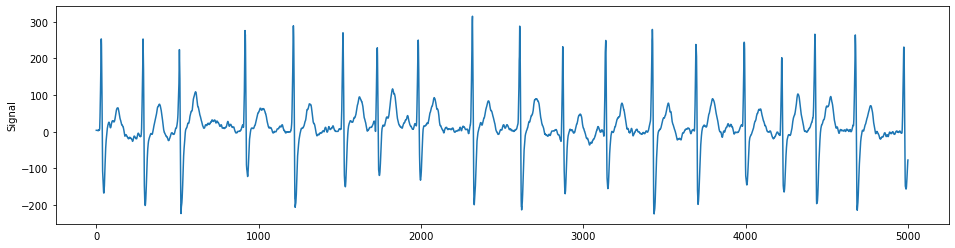

In [7]:
# 4b) plot the data for the first lead
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(4)

plt.plot(df_signal['I'])
# plt.plot(df_signal['I'][0:100])
plt.ylabel('Signal')
plt.show()

In [8]:
# 5) calculation of R, QRSon, QRSoff
R = int(doc['exportHeader']['patient']['examination']['analysis']['blockStandard']['eventTable']['event']['@tickOffset'])
QRSon = int(doc['exportHeader']['patient']['examination']['analysis']['blockStandard']['eventTable']['event']['leadValues'][0]['value'][7]['#text'])
QRSoff = int(doc['exportHeader']['patient']['examination']['analysis']['blockStandard']['eventTable']['event']['leadValues'][0]['value'][8]['#text'])

R_500 = R / 4 # from frequency 2000 Hz to 500 Hz
real_start_500 = int(R_500 - QRSon)
real_end_500 = int(R_500 + QRSoff)
print('Real start is {}, real end is {}, R position is {}'.format(real_start_500,real_end_500,R_500))

Real start is 264, real end is 344, R position is 200.0


In [11]:
df_signal_QRS

,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,...,leadoffIII,leadoffaVR,leadoffaVL,leadoffaVF,leadoffV1,leadoffV2,leadoffV3,leadoffV4,leadoffV5,leadoffV6
264,-9,-24,-14,18,2,-20,9,23,12,-14,...,0,0,0,0,0,0,0,0,0,0
265,-10,-24,-13,18,1,-19,6,27,15,-10,...,0,0,0,0,0,0,0,0,0,0
266,-10,-25,-13,19,1,-19,4,-11,-21,-9,...,0,0,0,0,0,0,0,0,0,0
267,-11,-25,-13,19,1,-19,0,-40,-30,-10,...,0,0,0,0,0,0,0,0,0,0
268,-12,-26,-12,19,0,-19,-3,-35,-10,-17,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,-5,-55,-49,31,22,-53,20,322,306,59,...,0,0,0,0,0,0,0,0,0,0
340,-6,-56,-49,32,22,-53,17,330,303,59,...,0,0,0,0,0,0,0,0,0,0
341,-6,-56,-49,33,21,-53,13,340,313,63,...,0,0,0,0,0,0,0,0,0,0
342,-6,-57,-48,33,20,-52,9,350,329,70,...,0,0,0,0,0,0,0,0,0,0


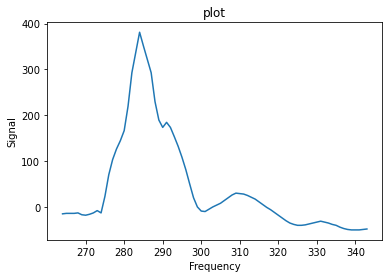

In [10]:
# 6) subset the data
df_signal_QRS = df_signal[real_start_500:real_end_500]
# R range
plt.plot(df_signal_QRS['III'])
# plt.ylabel('Signal')
plt.gca().set(xlabel='Frequency', ylabel='Signal', title = 'plot')
plt.show()

In [11]:
df_signal_QRS.shape

(80, 25)

#### Second file (patient)

In [67]:
# 1) read as a dictionary
with open('MUSE_20180111_155203_15000_A000.xml') as fd:
    doc2 = xmltodict.parse(fd.read())

In [68]:
# 2) find the relevant field in the dictionary
df2 = pd.json_normalize(doc2['exportHeader']['patient']['examination']['analysis']['blockExtended']['signal']['wave'])

In [69]:
df2.head(5)

,@lead,#text
0,I,7 6 7 8 8 8 6 4 1 -2 -7 -10 -10 -7 -4 1 6 11 1...
1,II,42 38 35 33 32 31 29 26 23 20 17 14 12 11 12 1...
2,III,35 32 29 26 24 21 21 20 20 21 21 21 20 18 14 1...
3,aVR,-23 -21 -19 -19 -19 -17 -15 -13 -10 -7 -3 0 0 ...
4,aVL,-14 -13 -12 -9 -9 -8 -8 -9 -10 -12 -14 -15 -14...


In [70]:
# 3) transform to data frame
for row, lead in enumerate(df['@lead']):
#     print(lead)
#     print(row)
    str_list = [int(index) for index in df['#text'][row].split()] # split the text into list of integers with space as separator
    if row == 0:
        df_signal2 = pd.DataFrame(str_list)
        df_signal2.columns = [lead]
#         print(df_signal)
    else:
        df_signal2[lead] = pd.DataFrame(str_list)

In [71]:
# 4a) data frame with leads
print('Dimension of the data frame: ', df_signal2.shape)
display(df_signal2.head(10))

Dimension of the data frame:  (5000, 25)


,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,...,leadoffIII,leadoffaVR,leadoffaVL,leadoffaVF,leadoffV1,leadoffV2,leadoffV3,leadoffV4,leadoffV5,leadoffV6
0,4,7,5,-5,0,5,-21,36,61,8,...,0,0,0,0,0,0,0,0,0,0
1,4,6,3,-4,1,4,-24,38,64,7,...,0,0,0,0,0,0,0,0,0,0
2,4,4,2,-3,1,3,-27,36,63,4,...,0,0,0,0,0,0,0,0,0,0
3,4,4,1,-3,2,2,-30,33,60,0,...,0,0,0,0,0,0,0,0,0,0
4,4,3,0,-3,2,2,-33,29,57,-3,...,0,0,0,0,0,0,0,0,0,0
5,4,2,-1,-3,3,1,-35,26,53,-8,...,0,0,0,0,0,0,0,0,0,0
6,4,1,-2,-2,3,0,-37,18,44,-12,...,0,0,0,0,0,0,0,0,0,0
7,4,0,-2,-2,4,-1,-38,14,57,-15,...,0,0,0,0,0,0,0,0,0,0
8,4,-1,-3,-1,4,-2,-39,4,24,-18,...,0,0,0,0,0,0,0,0,0,0
9,4,-2,-4,0,4,-3,-40,-1,9,-20,...,0,0,0,0,0,0,0,0,0,0


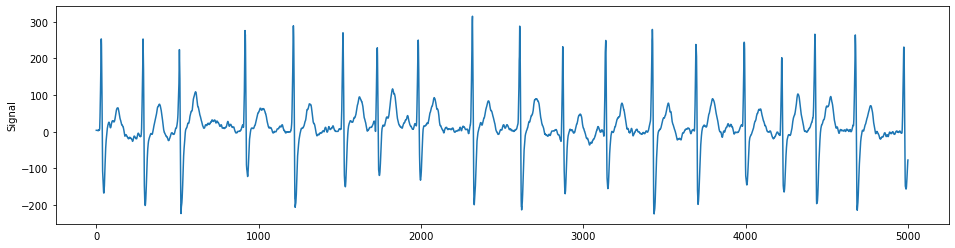

In [72]:
# 4b) plot the data for the first lead
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(4)

plt.plot(df_signal2['I'])
# plt.plot(df_signal['I'][0:100])
plt.ylabel('Signal')
plt.show()

In [73]:
# 5) calculation of R, QRSon, QRSoff
R = int(doc2['exportHeader']['patient']['examination']['analysis']['blockStandard']['eventTable']['event']['@tickOffset'])
QRSon = int(doc2['exportHeader']['patient']['examination']['analysis']['blockStandard']['eventTable']['event']['leadValues'][0]['value'][7]['#text'])
QRSoff = int(doc2['exportHeader']['patient']['examination']['analysis']['blockStandard']['eventTable']['event']['leadValues'][0]['value'][8]['#text'])

R_500 = R / 4 # from frequency 2000 Hz to 500 Hz
real_start_500 = int(R_500 - QRSon)
real_end_500 = int(R_500 + QRSoff)
print('Real start is {}, real end is {}, R position is {}'.format(real_start_500,real_end_500,R_500))

Real start is 280, real end is 300, R position is 200.0


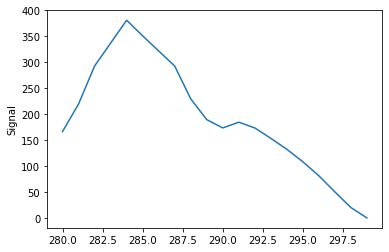

In [74]:
# 6) subset the data
df_signal_QRS = df_signal2[real_start_500:real_end_500]
# R range
plt.plot(df_signal_QRS['III'])
plt.ylabel('Signal')
plt.show()